[CNN 이미지 분류 모델]
- 이미지 데이터셋 준비
    - torchvision 내장 데이터셋 활용: CIFA 10
- 이미지 분류 모델
    - 커스텀 CNN 구현

- - -
[1] 모듈 로딩 및 데이터 준비

In [11]:
#모듈 로딩
import torch
import torch.nn
from torchvision.datasets import CIFAR10  
from torchvision.transforms import ToTensor     #torchvision 데이터 변환 관련 모듈
from torch.utils.data import DataLoader         #데이터셋 관련 모듈듈
import matplotlib.pyplot as plt

In [12]:
#데이터 로딩
dir_path='../data/'

#pytorch의 dataset 형태 로딩
cifar_ds=CIFAR10(dir_path,train=True,download=True,transform=ToTensor())

Files already downloaded and verified


In [13]:
type(cifar_ds)

torchvision.datasets.cifar.CIFAR10

In [14]:
#dataset 속성 확인
print(f'classes: {cifar_ds.classes}')
print(f'class_to_idx: {cifar_ds.class_to_idx}')
print(f'shape: {cifar_ds.data.shape}')
print(f'len(cifar_Ds.targets): {len(cifar_ds.targets)}')

classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_to_idx: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
shape: (50000, 32, 32, 3)
len(cifar_Ds.targets): 50000


- - -
[2] 데이터 로더
- 학습 시 배치 크기만큼 데이터와 타겟(라벨) 로딩

In [15]:
batch_size=50

cifar_dl=DataLoader(cifar_ds)   #배치사이즈는 디폴트가 1 => 1만 해서 데이터 잘 가져오는 지 확인 먼저

In [16]:
for data,target in cifar_dl:
    print(target)
    print(data.shape)       #print 결과: 배치사이즈, 채널(컬러 이미지라서 3), height, width
    break

tensor([6])
torch.Size([1, 3, 32, 32])


In [17]:
for data,target in cifar_dl:
    print(target)
    print(data.numpy().squeeze().shape)
    break

tensor([6])
(3, 32, 32)


In [18]:
for data,target in cifar_dl:
    print(target)
    print(data.shape)
    data=data.numpy().squeeze()
    print(data.shape)
    print(data.T.shape)
    break

tensor([6])
torch.Size([1, 3, 32, 32])
(3, 32, 32)
(32, 32, 3)


tensor([6])
torch.Size([1, 3, 32, 32])


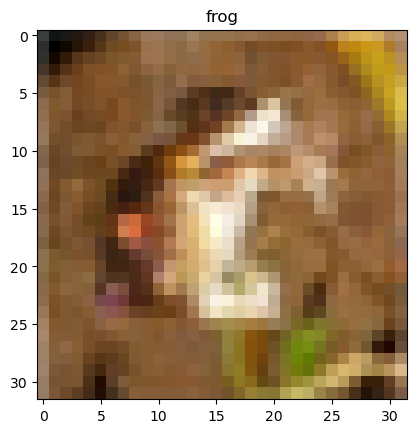

In [19]:
#dataset & dataloader 테스트

for data,target in cifar_dl:
    print(target)
    print(data.shape)
    data1=data.squeeze()
    plt.imshow(data1.transpose(0,2))
    plt.title(cifar_ds.classes[target.item()])
    break

- - -
[3] 커스텀 모델 설계 및 정의
- 이미지 분류 모델
    - 학습 방법: 지도 학습 > 분류 > 다중 분류(10가지)
    - 클래스 이름: Img_MCF
    - 클래스 구조: 특징 추출 부분 CNN + 학습 부분 FC
    - 부모 클래스: nn.Module

In [20]:
import torch.nn as nn
import torch.nn.functional as F

In [21]:
class Img_MCF(nn.Module):
    #모델 구조 설계: 생성자 메서드
    def __init__(self):
        #부모 생성
        super().__init__()

        #모델 층 구성
        # 1. 특징 추출 층
        self.in_layer=nn.Conv2d(3, 10, 3)    #shape: [배치사이즈, 채널, H, W] = in [1,3,32,32], out [1,10,32,32]
        self.in_layer=nn.Conv2d(10, 50, 3)
        self.in_layer=nn.Conv2d(50, 10, 3)
        self.p_layer=nn.MaxPool2d(2,stride=2)

        # 2. 학습 관련 층
        self.hd_layer=nn.Linear(10*15*15,50)
        self.out_layer=nn.Linear(50,10)

    #전방향(순방향) 학습 메서드
    def forward(self,input):
        output=self.in_layer(input)
        print(f'[output 1] {output.shape}')

        output=F.relu(output)
        print(f'[output 2] {output.shape}')

        output=self.p_layer(output)
        print(f'[output 3] {output.shape}')

        #4D - 2D (샘플 수, 피쳐 수)
        output=output.view(output.shape[0],-1)
        print(f'[output 4] {output.shape}')

        output=F.relu(self.hd_layer(output))
        print(f'[output 5] {output.shape}')

        output=self.out_layer(output)
        print(f'[output 6] {output.shape}')

        return output

In [22]:
class Img_MCF2(nn.Module):
    #모델 구조 설계: 생성자 메서드
    def __init__(self):
        #부모 생성
        super().__init__()

        #모델 층 구성
        # 1. 특징 추출 층
        self.cnn_layer=nn.Sequential(
            nn.Conv2d(3,10,3),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2)
        )

        self.cnn_layer2=nn.Sequential(
            nn.Conv2d(10,30,3),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2)
        )

        self.cnn_layer3=nn.Sequential(
            nn.Conv2d(10,30,3),
            nn.ReLU(),
            nn.Conv2d(30,10,3),
            nn.ReLU(),
            nn.Conv2d(10,30,3),
            nn.ReLU(),
            nn.AvgPool2d(2,stride=2)    #뽑은 특성들의 평균을 내기 위해 마지막에는 AvgPool2d 사용
        )

        # 2. 학습 관련 층
        self.hd_layer=nn.Linear(30*6*6,50)
        self.out_layer=nn.Linear(50,10)

    #전방향(순방향) 학습 메서드
    def forward(self,input):
        output=self.cnn_layer(input)
        print(f'[cnn layer output] {output.shape}')

        output=self.cnn_layer2(output)
        print(f'[cnn layer output] {output.shape}')

        #4D - 2D (샘플 수, 피쳐 수)
        output=output.view(output.shape[0],-1)
        print(f'[view output] {output.shape}')

        output=F.relu(self.hd_layer(output))
        print(f'[hd layer output] {output.shape}')

        output=self.out_layer(output)
        print(f'[out layer output] {output.shape}')

        return output

In [23]:
#테스트 모델 인스턴스 생성
m=Img_MCF2()

In [24]:
from torchinfo import summary

summary(m)

Layer (type:depth-idx)                   Param #
Img_MCF2                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       280
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-4                       2,730
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-7                       2,730
│    └─ReLU: 2-8                         --
│    └─Conv2d: 2-9                       2,710
│    └─ReLU: 2-10                        --
│    └─Conv2d: 2-11                      2,730
│    └─ReLU: 2-12                        --
│    └─AvgPool2d: 2-13                   --
├─Linear: 1-4                            54,050
├─Linear: 1-5                            510
Total params: 65,740
Trainable params: 65,740
Non-trainable params: 0

In [25]:
#테스트 데이터셋, 데이터로더

for data,target in cifar_dl:
    print(f'[target] {target}')
    print(data.shape)

    #전방향 학습
    pre=m(data)
    print(f'[pre] {pre.argmax(dim=1)}')
    break

[target] tensor([6])
torch.Size([1, 3, 32, 32])
[cnn layer output] torch.Size([1, 10, 15, 15])
[cnn layer output] torch.Size([1, 30, 6, 6])
[view output] torch.Size([1, 1080])
[hd layer output] torch.Size([1, 50])
[out layer output] torch.Size([1, 10])
[pre] tensor([3])


In [26]:
#모델 파라미터 확인
for name,param in m.named_parameters():
    print(f'[{name}]--------------- \n {param.shape}\n')

[cnn_layer.0.weight]--------------- 
 torch.Size([10, 3, 3, 3])

[cnn_layer.0.bias]--------------- 
 torch.Size([10])

[cnn_layer2.0.weight]--------------- 
 torch.Size([30, 10, 3, 3])

[cnn_layer2.0.bias]--------------- 
 torch.Size([30])

[cnn_layer3.0.weight]--------------- 
 torch.Size([30, 10, 3, 3])

[cnn_layer3.0.bias]--------------- 
 torch.Size([30])

[cnn_layer3.2.weight]--------------- 
 torch.Size([10, 30, 3, 3])

[cnn_layer3.2.bias]--------------- 
 torch.Size([10])

[cnn_layer3.4.weight]--------------- 
 torch.Size([30, 10, 3, 3])

[cnn_layer3.4.bias]--------------- 
 torch.Size([30])

[hd_layer.weight]--------------- 
 torch.Size([50, 1080])

[hd_layer.bias]--------------- 
 torch.Size([50])

[out_layer.weight]--------------- 
 torch.Size([10, 50])

[out_layer.bias]--------------- 
 torch.Size([10])



In [27]:
#인스턴스 속성 읽기
m.hd_layer

Linear(in_features=1080, out_features=50, bias=True)

In [32]:
#인스턴스 속성 변수 변경
m.out_layer=nn.Linear(10,30)

for name,param in m.out_layer.named_parameters():
    print(name,param,sep='\n')


weight
Parameter containing:
tensor([[ 1.5421e-01, -2.2686e-02,  5.1422e-02,  3.0029e-01, -2.1795e-01,
          3.7251e-02,  2.0908e-01,  2.3067e-01,  1.6751e-01,  1.3905e-01],
        [ 2.1385e-01, -1.2404e-01, -3.0016e-01,  2.0693e-01,  6.3657e-02,
          2.6937e-01, -1.8940e-01, -9.5338e-02,  1.0298e-01,  1.9316e-01],
        [-3.0407e-01,  1.4572e-02, -4.4498e-02, -2.2455e-01, -2.9834e-01,
          1.5995e-01, -1.2019e-02, -2.2076e-02,  8.1860e-02,  1.1275e-02],
        [ 1.1586e-01, -2.4439e-01, -6.6669e-02,  2.3505e-01,  2.3817e-01,
          8.3723e-02,  8.1917e-02,  1.5812e-01, -2.9152e-01,  1.7302e-01],
        [ 2.4420e-01, -2.5801e-01, -2.9407e-01, -2.8822e-01,  8.9435e-02,
          4.1211e-02,  8.4376e-02,  2.5753e-01, -5.0923e-02, -2.0978e-01],
        [-9.3819e-02, -8.8307e-02, -6.5209e-02, -7.0881e-02, -1.7867e-01,
         -2.9468e-01, -4.6168e-02,  3.1413e-01, -1.6647e-01,  2.4825e-01],
        [ 9.9381e-02,  1.4302e-01,  1.2234e-01,  1.3696e-01,  1.4560e-03,
   

In [29]:
m.out_layer

Linear(in_features=10, out_features=50, bias=True)